In [1]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy


**Data Preparation**

In [2]:
dataset_temp, dataset_info = tfds.load("mnist", split=["train+test"], shuffle_files=True, as_supervised=True, with_info=True)

2024-01-31 14:47:37.297957: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-01-31 14:47:37.297976: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-01-31 14:47:37.297979: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-01-31 14:47:37.298003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-31 14:47:37.298016: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
dataset_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/Users/cheesemac/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [4]:
len(dataset_temp[0])

70000

In [5]:
dataset = dataset_temp[0]
VAL_TEST_RATIO = 0.1
TRAIN_RATIO = 1 - VAL_TEST_RATIO*2
DATASET_SIZE = len(dataset)

train_dataset = dataset.take(int(DATASET_SIZE*TRAIN_RATIO))

val_dataset = dataset.skip(int(DATASET_SIZE*TRAIN_RATIO))
val_dataset = val_dataset.take(int(DATASET_SIZE*VAL_TEST_RATIO))

test_dataset = dataset.skip(int(DATASET_SIZE*(TRAIN_RATIO+VAL_TEST_RATIO)))

print(len(test_dataset))
print(len(val_dataset))
print(len(train_dataset))

7000
7000
56000


In [6]:
list(test_dataset.take(1))

[(<tf.Tensor: shape=(28, 28, 1), dtype=uint8, numpy=
  array([[[  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0]],
  
         [[  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
          [  0],
        

**Data Visualization**

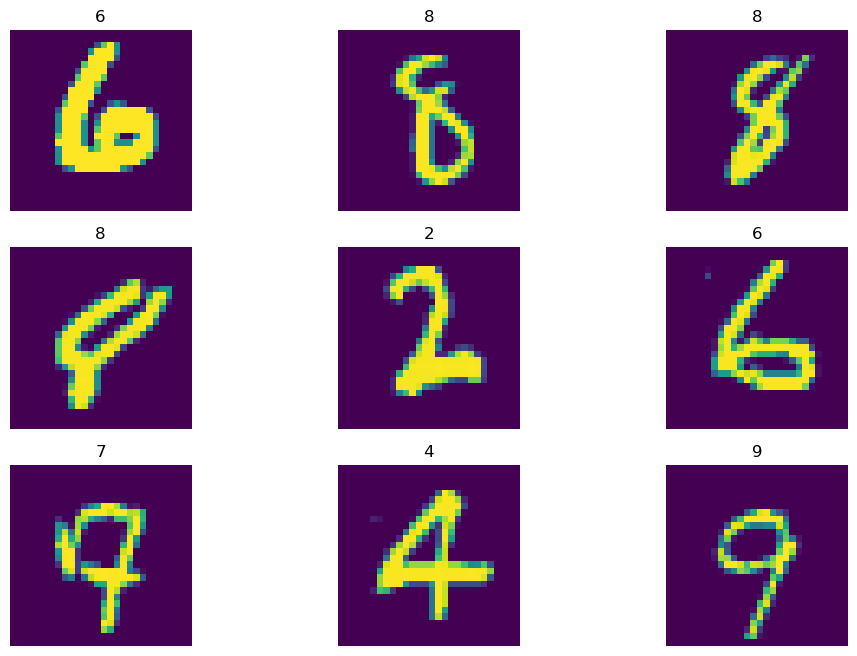

In [7]:
plt.figure(figsize=(12,8))
for i, (img, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(label.numpy())
    plt.axis("off")

plt.show();

**Data Processing**

In [8]:
def normalize_image(img, label):
    return img/255, label

In [9]:
train_dataset = train_dataset.map(normalize_image)
val_dataset = val_dataset.map(normalize_image)
test_dataset = test_dataset.map(normalize_image)

In [10]:
BUFFER_SIZE = 300
BATCH_SIZE = 250
train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

**Modelling**

In [11]:
IMG_SIZE = 28

Here we will use sigmoid activation, since the images are black and white

In [12]:
relu_model = Sequential([
    InputLayer(input_shape = (IMG_SIZE, IMG_SIZE, 1)),

    Conv2D(filters=64, kernel_size=3, padding="same", activation = "relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=32, kernel_size=3, padding="valid", activation = "relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),


    Flatten(),

    Dense(300, activation = "relu"),
    BatchNormalization(),

    Dense(84, activation = "relu"),
    BatchNormalization(),

    Dense(1, activation = "softmax")
])

relu_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        18464     
                                                                 
 batch_normalization_1 (Bat  (None, 12, 12, 32)        128       
 chNormalization)                                                
                                                        

In [13]:
relu_model.compile(optimizer=Adam(learning_rate=0.5),
                             loss = CategoricalCrossentropy(from_logits=True),
                             metrics = "accuracy")

In [14]:
process = relu_model.fit(train_dataset,validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20


/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)
/Users/cheesemac/Files/ML-Learning/Tensorflow_Course_env/lib/python3.8/site-packages/keras/src/backend.py:5562: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-01-31 14:47:39.211684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


222/224 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1124

2024-01-31 14:47:46.231253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


224/224 [==============================] - 8s 26ms/step - loss: 0.0000e+00 - accuracy: 0.1124 - val_loss: 0.0000e+00 - val_accuracy: 0.1123
Epoch 2/20
224/224 [==============================] - 6s 26ms/step - loss: 0.0000e+00 - accuracy: 0.1124 - val_loss: 0.0000e+00 - val_accuracy: 0.1123
Epoch 3/20
224/224 [==============================] - 6s 25ms/step - loss: 0.0000e+00 - accuracy: 0.1124 - val_loss: 0.0000e+00 - val_accuracy: 0.1123
Epoch 4/20
224/224 [==============================] - 6s 25ms/step - loss: 0.0000e+00 - accuracy: 0.1124 - val_loss: 0.0000e+00 - val_accuracy: 0.1123
Epoch 5/20
224/224 [==============================] - 5s 24ms/step - loss: 0.0000e+00 - accuracy: 0.1124 - val_loss: 0.0000e+00 - val_accuracy: 0.1123
Epoch 6/20
224/224 [==============================] - 5s 24ms/step - loss: 0.0000e+00 - accuracy: 0.1124 - val_loss: 0.0000e+00 - val_accuracy: 0.1123
Epoch 7/20
224/224 [==============================] - 6s 25ms/step - loss: 0.0000e+00 - accuracy: 0.1124 

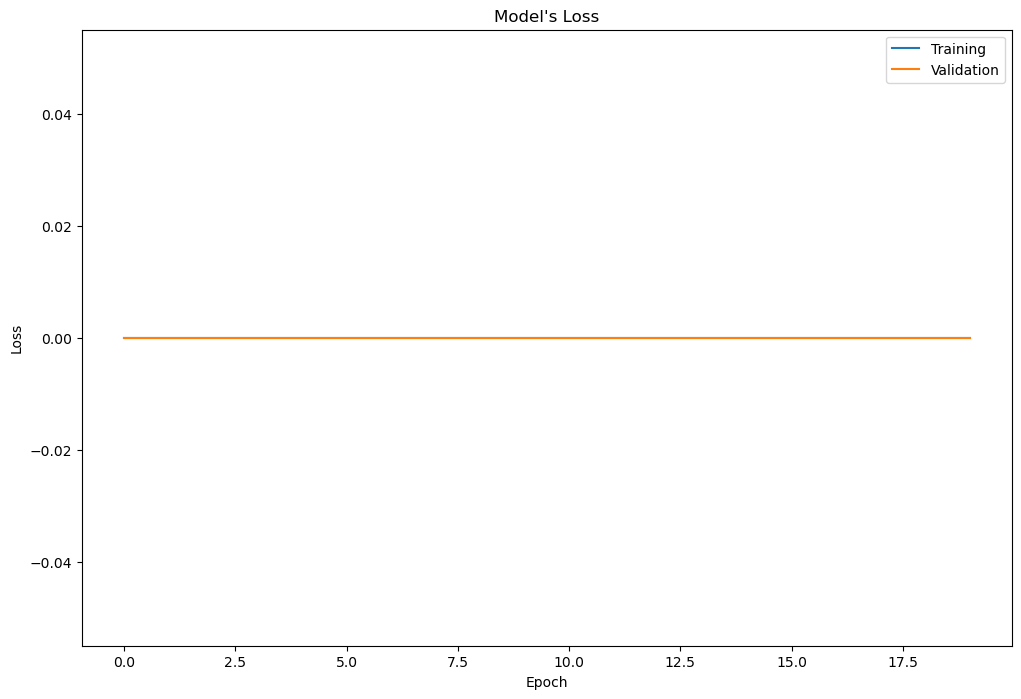

In [15]:
plt.figure(figsize=(12,8))
plt.plot(process.history["loss"])
plt.plot(process.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.title("Model's Loss")

plt.show();

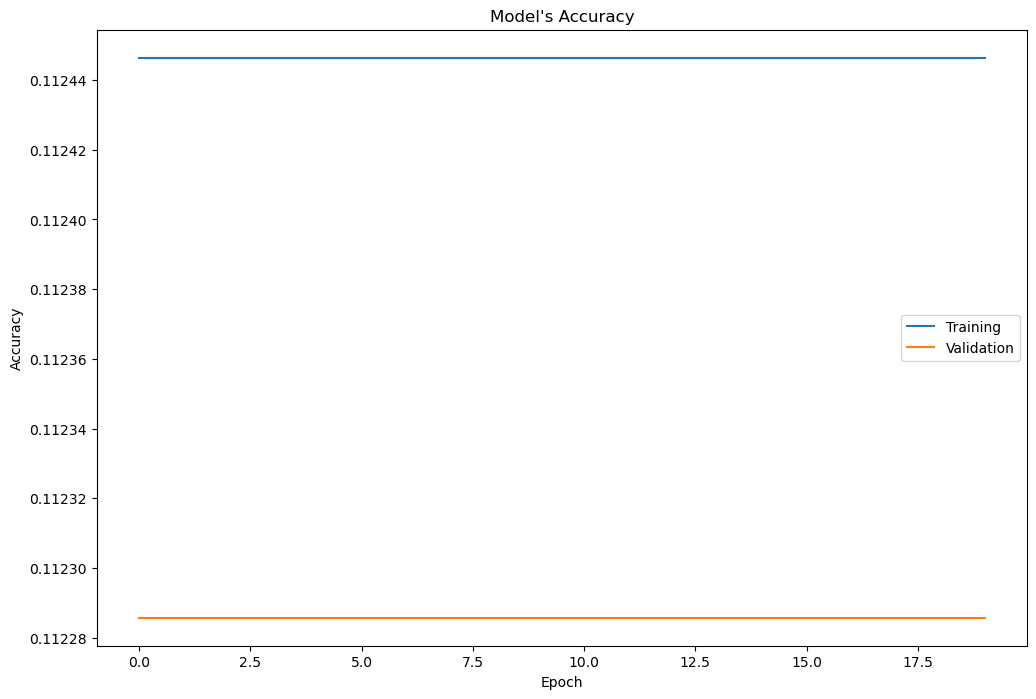

In [16]:
plt.figure(figsize=(12,8))
plt.plot(process.history["accuracy"])
plt.plot(process.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training", "Validation"])
plt.title("Model's Accuracy")

plt.show();